# Bank Marketing Data - A Decision Tree Approach

## Aim:
The aim of this attempt is to predict if the client will subscribe (yes/no) to a term deposit, by building a classification model using Decision Tree.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import metrics
%matplotlib inline

In [2]:
# Load data file
bank=pd.read_csv('./bank.csv')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Summay of data

### Categorical Variables :
**[1] job      :** admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur,
               housemaid, unknown, self-employed, student
<br>**[2] marital  :** married, single, divorced
<br>**[3] education:** secondary, tertiary, primary, unknown
<br>**[4] default  :** yes, no
<br>**[5] housing  :** yes, no
<br>**[6] loan     :** yes, no 
<br>**[7] deposit  :** yes, no ** (Dependent Variable)**
<br>**[8] contact  :** unknown, cellular, telephone
<br>**[9] month    :** jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
<br>**[10] poutcome:** unknown, other, failure, success

### Numerical Variables:
**[1] age 
<br>[2] balance
<br>[3] day
<br>[4] duration
<br>[5] campaign
<br>[6] pdays
<br>[7] previous **

In [3]:
# Check if the data set contains any null values - Nothing found!
bank[bank.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### Convert categorical data

In [4]:
# Make a copy for parsing
bank_data = bank.copy()

In [5]:
# Different types of job categories and their counts
bank_data.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [6]:
# Combine similar jobs into categiroes
bank_data['job'] = bank_data['job'].replace(['management', 'admin.'], 'white-collar')
bank_data['job'] = bank_data['job'].replace(['services','housemaid'], 'pink-collar')
bank_data['job'] = bank_data['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

In [7]:
# New value counts
bank_data.job.value_counts()

white-collar     3900
blue-collar      1944
technician       1823
other            1565
pink-collar      1197
self-employed     405
entrepreneur      328
Name: job, dtype: int64

#### ------------------------------ poutcome ------------------------------

In [8]:
bank_data.poutcome.value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

In [9]:
# Combine 'unknown' and 'other' as 'other' isn't really match with either 'success' or 'failure'
bank_data['poutcome'] = bank_data['poutcome'].replace(['other'] , 'unknown')
bank_data.poutcome.value_counts()

unknown    8863
failure    1228
success    1071
Name: poutcome, dtype: int64

#### ------------------------------ contact ------------------------------

In [10]:
# Drop 'contact', as every participant has been contacted. 
bank_data.drop('contact', axis=1, inplace=True)

#### ------------------------------ default ------------------------------

In [11]:
# values for "default" : yes/no
bank_data['default_cat'] = bank_data['default'].map( {'yes':1, 'no':0} )
bank_data.drop('default', axis=1,inplace = True)

#### ------------------------------ housing ------------------------------

In [12]:
# values for "housing" : yes/no
bank_data["housing_cat"]=bank_data['housing'].map({'yes':1, 'no':0})
bank_data.drop('housing', axis=1,inplace = True)

#### ------------------------------ loan ------------------------------

In [13]:
# values for "loan" : yes/no
bank_data["loan_cat"] = bank_data['loan'].map({'yes':1, 'no':0})
bank_data.drop('loan', axis=1, inplace=True)

#### ------------------------------ month, day ------------------------------

In [14]:
# day  : last contact day of the month
# month: last contact month of year
# Drop 'month' and 'day' as they don't have any intrinsic meaning
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

#### ------------------------------ deposit ------------------------------

In [15]:
# values for "deposit" : yes/no
bank_data["deposit_cat"] = bank_data['deposit'].map({'yes':1, 'no':0})
bank_data.drop('deposit', axis=1, inplace=True)

#### ------------------------------ pdays ------------------------------

In [16]:
# pdays: number of days that passed by after the client was last contacted from a previous campaign
#       -1 means client was not previously contacted

print("Customers that have not been contacted before:", len(bank_data[bank_data.pdays==-1]))
print("Maximum values on padys    :", bank_data['pdays'].max())

Customers that have not been contacted before: 8324
Maximum values on padys    : 854


In [17]:
# Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 10000

In [18]:
# Create a new column: recent_pdays 
#numpy.where(condition[, x, y]) Where True, yield x, otherwise yield y.
bank_data['recent_pdays'] = np.where(bank_data['pdays'], 1/bank_data.pdays, 1/bank_data.pdays)

# Drop 'pdays'
bank_data.drop('pdays', axis=1, inplace = True)

In [19]:
bank_data.tail()

,age,job,marital,education,balance,duration,campaign,previous,poutcome,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays
11157,33,blue-collar,single,primary,1,257,1,0,unknown,0,1,0,0,0.000100
11158,39,pink-collar,married,secondary,733,83,4,0,unknown,0,0,0,0,0.000100
11159,32,technician,single,secondary,29,156,2,0,unknown,0,0,0,0,0.000100
11160,43,technician,married,secondary,0,9,2,5,failure,0,0,1,0,0.005814
11161,34,technician,married,secondary,0,628,1,0,unknown,0,0,0,0,0.000100


### ------------------------------ Convert to dummy values ------------------------------

In [20]:
# Convert categorical variables to dummies
bank_with_dummies = pd.get_dummies(data=bank_data, columns = ['job', 'marital', 'education', 'poutcome'], \
                                   prefix = ['job', 'marital', 'education', 'poutcome'])
bank_with_dummies.head()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
0,59,2343,1042,1,0,0,1,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
1,56,45,1467,1,0,0,0,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
2,41,1270,1389,1,0,0,1,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
3,55,2476,579,1,0,0,1,0,1,0.0001,...,0,1,0,0,1,0,0,0,0,1
4,54,184,673,2,0,0,0,0,1,0.0001,...,0,1,0,0,0,1,0,0,0,1


In [21]:
bank_with_dummies.shape

(11162, 27)

In [22]:
bank_with_dummies.describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,...,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,371.993818,2.508421,0.832557,0.015051,0.473123,0.130801,0.473840,0.003124,...,0.115839,0.568984,0.315176,0.134385,0.490593,0.330496,0.044526,0.110016,0.095951,0.794033
std,11.913369,3225.413326,347.128386,2.722077,2.292007,0.121761,0.499299,0.337198,0.499338,0.030686,...,0.320047,0.495241,0.464607,0.341080,0.499934,0.470413,0.206270,0.312924,0.294537,0.404424
min,18.000000,-6847.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,122.000000,138.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,550.000000,255.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,49.000000,1708.000000,496.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.001919,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,81204.000000,3881.000000,63.000000,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Observations on whole population

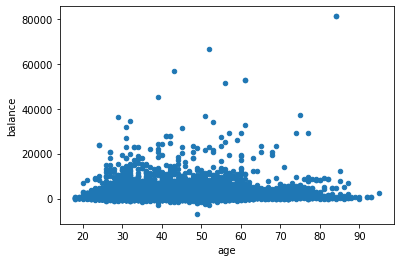

In [23]:
# Scatterplot showing age and balance
bank_with_dummies.plot(kind='scatter', x='age', y='balance');

# Across all ages, majority of people have savings of less than 20000.

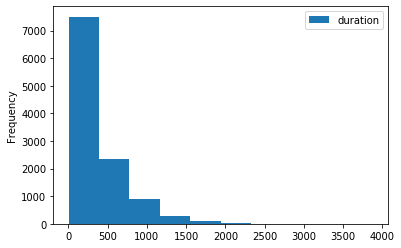

In [24]:
bank_with_dummies.plot(kind='hist', x='poutcome_success', y='duration');

#### Analysis on people who sign up for a term deposite

In [25]:
# People who sign up to a term deposite
bank_with_dummies[bank_data.deposit_cat == 1].describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.0,5289.000000,...,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000
mean,41.670070,1804.267915,537.294574,2.141047,1.170354,0.009832,0.365854,0.091511,1.0,0.004238,...,0.117603,0.520892,0.361505,0.111741,0.463226,0.377387,0.047646,0.116846,0.184912,0.698242
std,13.497781,3501.104777,392.525262,1.921826,2.553272,0.098676,0.481714,0.288361,0.0,0.035686,...,0.322167,0.499611,0.480482,0.315078,0.498693,0.484779,0.213036,0.321267,0.388263,0.459064
min,18.000000,-3058.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,210.000000,244.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,733.000000,426.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,50.000000,2159.000000,725.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.005128,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,81204.000000,3881.000000,32.000000,58.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> ## Classification

In [26]:
# make a copy
bankcl = bank_with_dummies

In [27]:
# The Correltion matrix
corr = bankcl.corr()
corr

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
age,1.000000,0.112300,0.000189,-0.005278,0.020169,-0.011425,-0.168700,-0.031418,0.034901,0.019102,...,0.186349,0.318436,-0.467799,0.231150,-0.094400,-0.101372,0.077761,-0.008071,0.062114,-0.038992
balance,0.112300,1.000000,0.022436,-0.013894,0.030805,-0.060954,-0.077092,-0.084589,0.081129,-0.004379,...,-0.017586,0.025431,-0.014994,-0.000673,-0.070609,0.069128,0.014596,0.001695,0.045603,-0.034524
duration,0.000189,0.022436,1.000000,-0.041557,-0.026716,-0.009760,0.035051,-0.001914,0.451919,-0.014868,...,0.021364,-0.036179,0.023847,0.013405,0.003820,-0.006813,-0.015887,-0.033966,-0.022578,0.042725
campaign,-0.005278,-0.013894,-0.041557,1.000000,-0.049699,0.030975,0.006660,0.034722,-0.128081,-0.026296,...,-0.006828,0.047722,-0.046165,0.019915,-0.013834,-0.005427,0.012976,-0.080188,-0.091807,0.128907
previous,0.020169,0.030805,-0.026716,-0.049699,1.000000,-0.035273,-0.000840,-0.022668,0.139867,0.122076,...,-0.026566,-0.005176,0.023817,-0.024852,-0.004620,0.028146,-0.011898,0.335870,0.325477,-0.496921
default_cat,-0.011425,-0.060954,-0.009760,0.030975,-0.035273,1.000000,0.011076,0.076434,-0.040680,-0.011290,...,0.019633,-0.006819,-0.006255,0.013858,-0.000618,-0.011768,0.005421,-0.024650,-0.040272,0.048403
housing_cat,-0.168700,-0.077092,0.035051,0.006660,-0.000840,0.011076,1.000000,0.076761,-0.203888,-0.029350,...,0.007430,0.036305,-0.043817,0.017002,0.118514,-0.114955,-0.053191,0.087741,-0.136299,0.031375
loan_cat,-0.031418,-0.084589,-0.001914,0.034722,-0.022668,0.076434,0.076761,1.000000,-0.110580,-0.012697,...,0.026463,0.044148,-0.065288,0.006854,0.079583,-0.067513,-0.050249,0.006264,-0.080370,0.053686
deposit_cat,0.034901,0.081129,0.451919,-0.128081,0.139867,-0.040680,-0.203888,-0.110580,1.000000,0.034457,...,0.005228,-0.092157,0.094632,-0.063002,-0.051952,0.094598,0.014355,0.020714,0.286642,-0.224785
recent_pdays,0.019102,-0.004379,-0.014868,-0.026296,0.122076,-0.011290,-0.029350,-0.012697,0.034457,1.000000,...,-0.020253,0.009583,0.003736,-0.007034,-0.017129,0.017346,0.013590,0.051422,0.119598,-0.126890


Text(0.5, 1, 'Heatmap of Correlation Matrix')

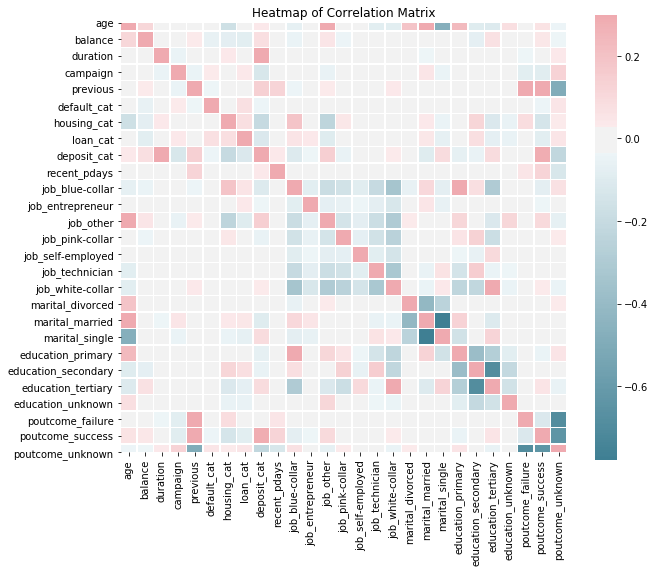

In [28]:
# Heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

> ## Build the Data Model

In [29]:
# Train-Test split: 20% test data
data_drop_deposite = bankcl.drop('deposit_cat', 1)
label = bankcl.deposit_cat
data_train, data_test, label_train, label_test = train_test_split(data_drop_deposite, label, test_size = 0.2, random_state = 50)

In [38]:
rf = ensemble.RandomForestClassifier(n_estimators=100,max_depth=None)
rf.fit(data_train, label_train)
rf_score_train = rf.score(data_train, label_train)
print("Training score: ",rf_score_train)
rf_score_test = rf.score(data_test, label_test)
print("Testing score: ",rf_score_test)

Training score:  1.0
Testing score:  0.8051948051948052


In [39]:
rf.predict(data_train[0:1])

array([1], dtype=int64)